# cell type情報

1. 野生型マウス海馬CA1領域の切片（CK2WtCA1）
2. 野生型マウス海馬歯状回領域の切片（CK2WT）
3. CamK2aヘテロノックアウトマウス海馬歯状回（CK2KO）
4. CamK2aヘテロノックアウトマウス海馬（CK2KOCA1）
5. マウス胎仔脳切片で神経幹細胞が多く集積しているところ
6. マウス胎仔脳切片で分化した未成熟ニューロンが集積しているところ


# 染色種類

**クラス1 ~ クラス4**

* 488は転写共役因子`CTCF`を染色したものです。CTCFは`３次元的にゲノム領域を分けるboundaryに集積する`（TADの境界に集積する）タンパク質です。

* 555はヒストンH3タンパク質の９番目のリジン残基がトリメチル化されたもの`（H3K9me3）`を染色しております。H3K9me3は`ヘテロクロマチン`に集積します。

**クラス5 ~ クラス6**

* 488はエンハンサー領域に集積する`H3K4me1`となっております。
* 555は核膜に存在する`LaminB1`となっております。

# SegmentData

* **1_488_STED_decon** : 35
* **2_488_STED_decon** : 30
* **3_488_STED_decon** : 39
* **4_488_STED_decon** : 24


* **5_488_STED_decon** : 30
* **6_488_STED_decon** : 54

# データ確認

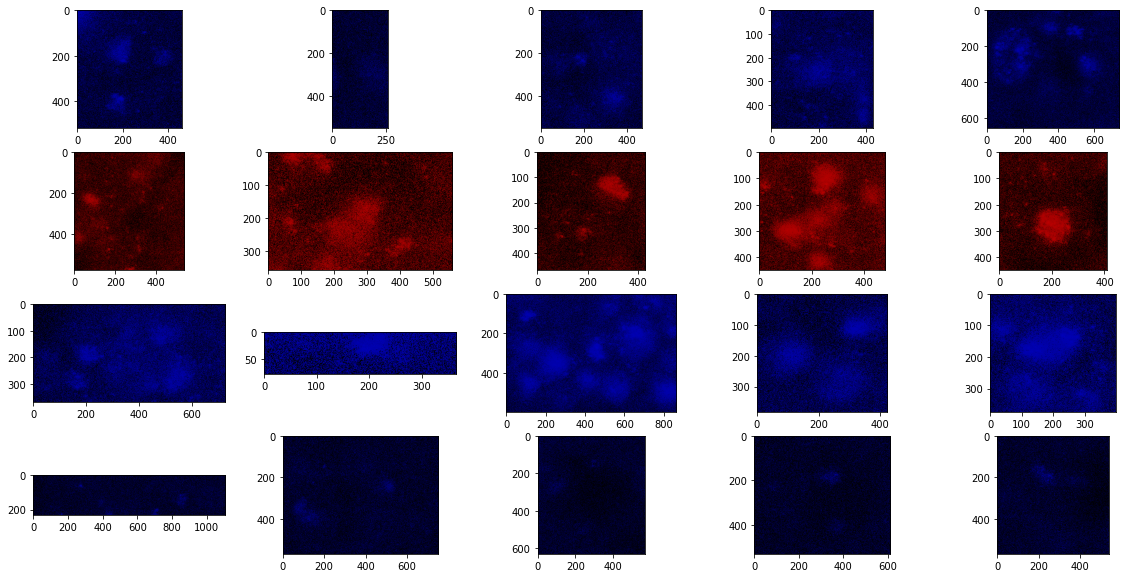

In [1]:
import cv2,os
import numpy as np
from matplotlib import pyplot as plt

path = "./SegmentData/1234_STED_H3K9me3/"
name = "_555_STED_gamma10_"
classes = ["1","2","3","4"]

fig, ax = plt.subplots(2,2, figsize = (20,10))
subnumber=1
for n in range(4):
    for i in range(5):
#         print(path+classes[n]+name+str(i)+".tif")
        img = cv2.imread(path+classes[n]+name+str(i)+".tif")
        plt.subplot(4,5,subnumber)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        subnumber+=1
        
plt.show()

# データの読み込み

In [2]:
path = "./SegmentData/1234_STED_H3K9me3/"
DataPath=[]
DataLabel=[]

for root,dirs,files in os.walk(path):
    for file_name in files:
        path = os.path.join(root,file_name)
        label = os.path.join(file_name)
        DataPath.append(path)
        DataLabel.append(label[0])
# all_files.remove("../Database/KIMIA_Path_960/train/.DS_Store")
# file_label.remove(".")
print(len(DataPath))
print(len(DataLabel))

128
128


DataPath:  ./SegmentData/1234_STED_H3K9me3/4_555_STED_gamma10_3.tif
DataLabel:  4
DataPath[1].shape:  (529, 609, 3)


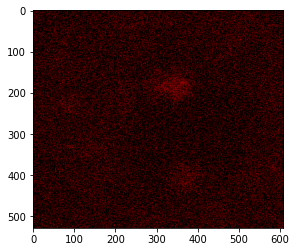

In [3]:
print("DataPath: ",DataPath[1])
print("DataLabel: ",DataLabel[1])

img = cv2.imread(DataPath[1])
print("DataPath[1].shape: ", img.shape)
plt.imshow(img)
plt.show()

# データ処理

## 1. Max_shape_0 , Max_shape_1を調べる

In [4]:
# Max_shape_0 , Max_shape_1を調べる
from tqdm import tqdm
DataSize=[]
DataSmallPath=[]
shape_0=0
shape_1=0
for i in tqdm(range(len(DataPath))):
    imgSize = cv2.imread(DataPath[i]).shape
    DataSize.append(imgSize)
    if imgSize[0]>shape_0:
        shape_0=imgSize[0]
    if imgSize[1]>shape_1:
        shape_1=imgSize[1]
#     if imgSize[0]<=512 and imgSize[1]<=512:
#         DataSmallPath.append(DataPath[i])
        
print("Max_shape_0: ", shape_0)
print("Max_shape_1: ", shape_1)
print("")
# print("len(DataSmallPath): ", len(DataSmallPath))
# Max_shape_0 = 1049
# Max_shape_1 = 1779

100%|██████████| 128/128 [00:00<00:00, 217.19it/s]

Max_shape_0:  1049
Max_shape_1:  1359



## 2. 512*3に補正し、サイズを一致する

In [5]:
#　同じサイズにする
DataResize=[]

Max_shape_0 = 512*3
Max_shape_1 = 512*3

for path in DataPath:
    img = cv2.imread(path)
    imgSize = img.shape
    
    top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2
    left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2
    
    if (imgSize[0] % 2) != 0:
        top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2+1
        
    if (imgSize[1] % 2) != 0:     
        left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2+1
    
    img_pad = cv2.copyMakeBorder(img,top_size,bottom_size,left_size,right_size,cv2.BORDER_CONSTANT,value=(0,0,0))
  
    DataResize.append(img_pad)

print("DataResize: ",len(DataResize))

DataResize:  128


DataResize:  (128, 1536, 1536, 3)
DataPath[1].shape:  (529, 609, 3)


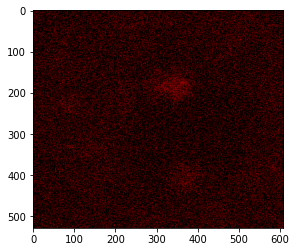

DataResize[1].shape:  (1536, 1536, 3)


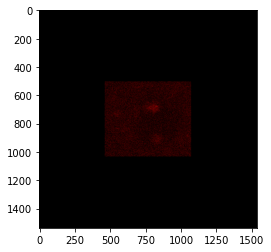

In [6]:
DataResize = np.array(DataResize)
print("DataResize: ", DataResize.shape)

img = cv2.imread(DataPath[1])
print("DataPath[1].shape: ", img.shape)
plt.imshow(img)
plt.show()

print("DataResize[1].shape: ", DataResize[1].shape)
plt.imshow(DataResize[1])
plt.show()

## 3. bin_ndarrayによる512*512にresizeする

In [7]:
DataBinResize = []
def bin_ndarray(ndarray, new_shape, operation):
    operation = operation.lower()
    if not operation in ['sum', 'mean']:
        raise ValueError("Operation not supported.")
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d,c in zip(new_shape,
                                                  ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        op = getattr(ndarray, operation)
        ndarray = op(-1*(i+1))
    return ndarray

for img in DataResize:
    imgresize = bin_ndarray(img, new_shape=(512,512,3), operation='mean')
    DataBinResize.append(imgresize)

DataBinResize:  (128, 512, 512, 3)
DataPath[1].shape:  (529, 609, 3)


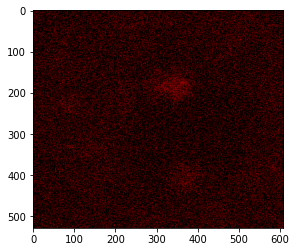

DataResize[1].shape:  (1536, 1536, 3)


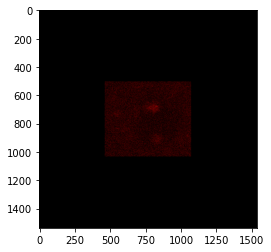

DataBinResize[1].shape:  (512, 512, 3)


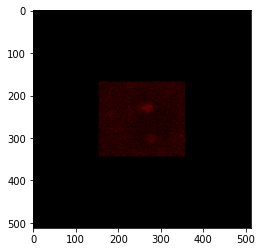

In [8]:
DataBinResize = np.array(DataBinResize)
print("DataBinResize: ", DataBinResize.shape)

img = cv2.imread(DataPath[1])
print("DataPath[1].shape: ", img.shape)
plt.imshow(img)
plt.show()

print("DataResize[1].shape: ", DataResize[1].shape)
plt.imshow(DataResize[1])
plt.show()

print("DataBinResize[1].shape: ", DataBinResize[1].shape)
plt.imshow(DataBinResize[1]/255)
plt.show()

## ラベルを作る

In [15]:
da = "HOME/DDDog/210901PictData/SegmentData/1234_STED_H3K9me3/4_555_STED_gamma10_3.tif"
print(da)
for i in range(len(da)):
    print(str(i)+": "+da[i])

HOME/DDDog/210901PictData/SegmentData/1234_STED_H3K9me3/4_555_STED_gamma10_3.tif
0: H
1: O
2: M
3: E
4: /
5: D
6: D
7: D
8: o
9: g
10: /
11: 2
12: 1
13: 0
14: 9
15: 0
16: 1
17: P
18: i
19: c
20: t
21: D
22: a
23: t
24: a
25: /
26: S
27: e
28: g
29: m
30: e
31: n
32: t
33: D
34: a
35: t
36: a
37: /
38: 1
39: 2
40: 3
41: 4
42: _
43: S
44: T
45: E
46: D
47: _
48: H
49: 3
50: K
51: 9
52: m
53: e
54: 3
55: /
56: 4
57: _
58: 5
59: 5
60: 5
61: _
62: S
63: T
64: E
65: D
66: _
67: g
68: a
69: m
70: m
71: a
72: 1
73: 0
74: _
75: 3
76: .
77: t
78: i
79: f


In [11]:
data_img = DataBinResize

data_label=[]
for i in range(len(DataPath)):
    data_label.append(int(DataPath[i][32])-1)
data_label=np.array(data_label)

print("data_img.shape: ", data_img.shape)
print("data_label.shape: ", data_label.shape)

data_img.shape:  (128, 512, 512, 3)
data_label.shape:  (128,)


In [12]:
from sklearn.model_selection import train_test_split

data_img_class=[[],[],[],[]]
data_label_class=[[],[],[],[]]

for i in range(len(data_label)):
    data_img_class[data_label[i]].append(data_img[i])
    data_label_class[data_label[i]].append(data_label[i])
    
X_train, X_test, y_train, y_test = [],[],[],[]

for i in range(len(data_img_class)):
    X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(np.array(data_img_class[i]), np.array(data_label_class[i]), test_size=0.3, random_state=42)        
    X_train.extend(X_train_class), X_test.extend(X_test_class), y_train.extend(y_train_class), y_test.extend(y_test_class)

X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

# shuffle
train_permutation = np.random.permutation(X_train.shape[0])
test_permutation = np.random.permutation(X_test.shape[0])
X_train,y_train, = X_train[train_permutation,:,:,:], y_train[train_permutation] 
X_test,y_test = X_test[test_permutation,:,:,:], y_test[test_permutation]

print("Total number of train : ", len(y_train))
print("train_class_1 num : ", y_train.tolist().count(0))
print("train_class_2 num : ", y_train.tolist().count(1))
print("train_class_3 num : ", y_train.tolist().count(2))
print("train_class_4 num : ", y_train.tolist().count(3))
print("")
print("Total number of test : ", len(y_test))
print("test_class_1 num : ", y_test.tolist().count(0))
print("test_class_2 num : ", y_test.tolist().count(1))
print("test_class_3 num : ", y_test.tolist().count(2))
print("test_class_4 num : ", y_test.tolist().count(3))

Total number of train :  88
train_class_1 num :  24
train_class_2 num :  21
train_class_3 num :  27
train_class_4 num :  16

Total number of test :  40
test_class_1 num :  11
test_class_2 num :  9
test_class_3 num :  12
test_class_4 num :  8


In [13]:
# train data augmentation 
n = len(X_train)
X_augment=X_train
y_augment=y_train

for i in tqdm(range(n)):
    img = X_train[i]
    label = y_train[i]

    #水平镜像
    h_flip=cv2.flip(img,1)
    X_augment=np.concatenate((X_augment,h_flip[np.newaxis,:]),axis=0)
    y_augment=np.append(y_augment,label)
    
    #垂直镜像
    v_flip=cv2.flip(img,0)
    X_augment=np.concatenate((X_augment,v_flip[np.newaxis,:]),axis=0)
    y_augment=np.append(y_augment,label)
    
    #水平垂直镜像
    hv_flip=cv2.flip(img,-1)
    X_augment=np.concatenate((X_augment,hv_flip[np.newaxis,:]),axis=0)
    y_augment=np.append(y_augment,label)
    
    #平移矩阵[[1,0,-100],[0,1,-12]]
    M=np.array([[1,0,-100],[0,1,-12]],dtype=np.float32)
    translation=cv2.warpAffine(img,M,(512,512))
    X_augment=np.concatenate((X_augment,translation[np.newaxis,:]),axis=0)
    y_augment=np.append(y_augment,label)

    #45度旋转
    rows,cols=img.shape[:2]
    M=cv2.getRotationMatrix2D((cols/2,rows/2),45,1)
    rotate_45=cv2.warpAffine(img,M,(cols,rows))
    X_augment=np.concatenate((X_augment,rotate_45[np.newaxis,:]),axis=0)
    y_augment=np.append(y_augment,label)
    
    #60度旋转
    rows,cols=img.shape[:2]
    M=cv2.getRotationMatrix2D((cols/2,rows/2),60,1)
    rotate_60=cv2.warpAffine(img,M,(cols,rows))
    X_augment=np.concatenate((X_augment,rotate_60[np.newaxis,:]),axis=0)
    y_augment=np.append(y_augment,label)
         
    #90度旋转
    rows,cols=img.shape[:2]
    M=cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
    rotate_90=cv2.warpAffine(img,M,(cols,rows))
    X_augment=np.concatenate((X_augment,rotate_90[np.newaxis,:]),axis=0)
    y_augment=np.append(y_augment,label)
    
print("X_augment.shape: ", X_augment.shape)
print("y_augment.shape: ", y_augment.shape)


100%|██████████| 88/88 [17:21<00:00, 11.83s/it]

X_augment.shape:  (792, 512, 512, 3)
y_augment.shape:  (792,)


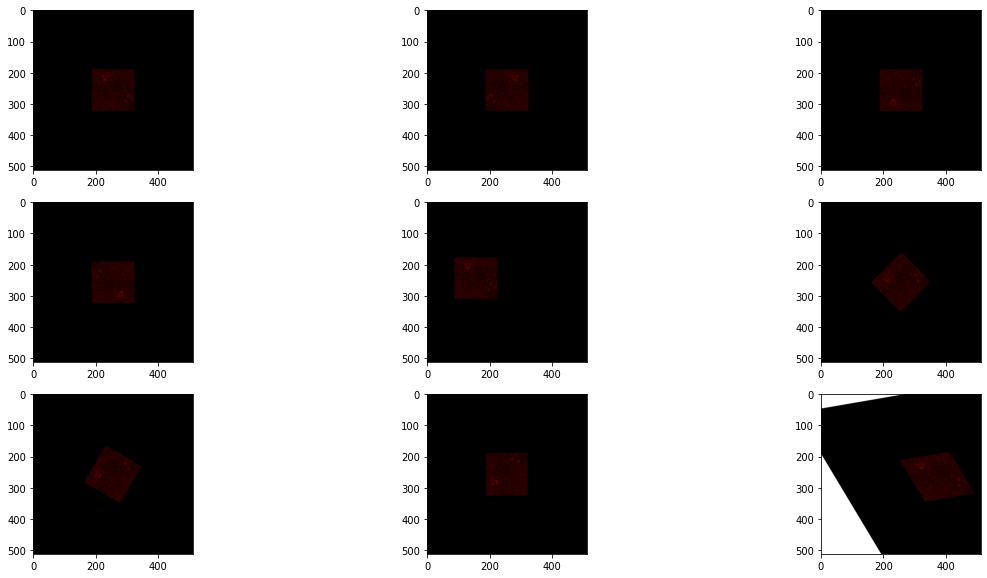

In [14]:
augment_confirm = [img, h_flip, v_flip, hv_flip, translation, rotate_45, rotate_60, rotate_90, affine]
fig, ax = plt.subplots(2,2, figsize = (20,10))
subnumber=1
for n in range(3):
    for i in range(3):
        img = augment_confirm[subnumber-1]
        plt.subplot(3,3,subnumber)
        plt.imshow(img/255)
        subnumber+=1
        
plt.show()

In [16]:
X_train = X_augment
y_train = y_augment

# shuffle
train_permutation = np.random.permutation(X_train.shape[0])
test_permutation = np.random.permutation(X_test.shape[0])
X_train,y_train, = X_train[train_permutation,:,:,:], y_train[train_permutation] 
X_test,y_test = X_test[test_permutation,:,:,:], y_test[test_permutation]

print("Total number of train : ", len(y_train))
print("train_class_1 num : ", y_train.tolist().count(0))
print("train_class_2 num : ", y_train.tolist().count(1))
print("train_class_3 num : ", y_train.tolist().count(2))
print("train_class_4 num : ", y_train.tolist().count(3))
print("")
print("Total number of test : ", len(y_test))
print("test_class_1 num : ", y_test.tolist().count(0))
print("test_class_2 num : ", y_test.tolist().count(1))
print("test_class_3 num : ", y_test.tolist().count(2))
print("test_class_4 num : ", y_test.tolist().count(3))

Total number of train :  792
train_class_1 num :  216
train_class_2 num :  189
train_class_3 num :  243
train_class_4 num :  144

Total number of test :  40
test_class_1 num :  11
test_class_2 num :  9
test_class_3 num :  12
test_class_4 num :  8


# データ前処理

In [17]:
import torch
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
torch.__version__

'1.9.0+cu102'

In [18]:
class train_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, y_train):
        data = x_train.astype('float32')
        self.x_train = []
        for i in range(data.shape[0]):
            self.x_train.append(Image.fromarray(np.uint8(data[i])))
        self.y_train = y_train
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.transform(self.x_train[idx]), torch.tensor(y_train[idx], dtype=torch.long)

trainval_data = train_dataset(X_train, y_train)
test_data = train_dataset(X_test, y_test)

In [19]:
batch_size = 32

val_size = int(len(trainval_data)*0.2)
train_size = len(trainval_data) - val_size

train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True
)

# CNNモデル

In [20]:
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

rng = np.random.RandomState(1234)
random_state = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
conv_net = nn.Sequential(
    nn.Conv2d(3, 32, 5),              # Conv 512x512x3 -> 508x508x32
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # Pool 508x508x32 -> 254x254x32
    
    nn.Conv2d(32, 32, 5),             # Conv 254x254x32-> 250x250x32
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # Pool 250x250x32 -> 125x125x32

    nn.Conv2d(32, 64, 3),            # Conv 125x125x32 -> 123x123x64
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # Pool 123x123x64 -> 61x61x64
    
    nn.Conv2d(64, 64, 3),            # Conv 61x61x64 -> 59x59x64
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # Pool 59x59x64 -> 29x29x64

    nn.Conv2d(64, 128, 3),           # Conv 29x29x64-> 27x27x128
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # Pool 27x27x128 -> 13x13x128

    nn.Conv2d(128, 128, 3),           # Conv 13x13x128 -> 11x11x128
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # Pool 11x11x128-> 5x5x128
    
    nn.Flatten(),
    
    nn.Linear(5*5*128, 1024),
    torch.nn.Dropout(0.5),
    nn.ReLU(),
    
    nn.Linear(1024, 256),
    torch.nn.Dropout(0.5),
    nn.ReLU(),
    
    nn.Linear(256, 4)
)

losstrain=[]
lossvalid=[]
Accuracytrain=[]
Accuracyvalid=[]


device = 'cuda'
conv_net.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (16): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (17): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [21]:
n_epochs = 100
lr = 0.01
optimizer = optim.SGD(conv_net.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()  

for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []
    # Train
    conv_net.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]
        conv_net.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        y = conv_net.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())
    # Evaluate
    conv_net.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        y = conv_net.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())
    # Visualize loss & accuracy    
    losstrain.append(np.mean(losses_train))   
    Accuracytrain.append(acc_train/n_train)
    lossvalid.append(np.mean(losses_train))
    Accuracyvalid.append(acc_val/n_val)
    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(epoch,np.mean(losses_train),acc_train/n_train,np.mean(losses_valid),acc_val/n_val))

EPOCH: 0, Train [Loss: 1.235, Accuracy: 0.468], Valid [Loss: 1.390, Accuracy: 0.304]
EPOCH: 1, Train [Loss: 0.939, Accuracy: 0.574], Valid [Loss: 1.304, Accuracy: 0.411]
EPOCH: 2, Train [Loss: 0.791, Accuracy: 0.614], Valid [Loss: 0.975, Accuracy: 0.709]
EPOCH: 3, Train [Loss: 0.682, Accuracy: 0.733], Valid [Loss: 0.691, Accuracy: 0.665]
EPOCH: 4, Train [Loss: 0.572, Accuracy: 0.822], Valid [Loss: 0.580, Accuracy: 0.880]
EPOCH: 5, Train [Loss: 0.482, Accuracy: 0.847], Valid [Loss: 0.427, Accuracy: 0.867]
EPOCH: 6, Train [Loss: 0.418, Accuracy: 0.839], Valid [Loss: 0.958, Accuracy: 0.582]
EPOCH: 7, Train [Loss: 0.352, Accuracy: 0.874], Valid [Loss: 0.828, Accuracy: 0.563]
EPOCH: 8, Train [Loss: 0.308, Accuracy: 0.894], Valid [Loss: 0.613, Accuracy: 0.741]
EPOCH: 9, Train [Loss: 0.379, Accuracy: 0.855], Valid [Loss: 0.317, Accuracy: 0.873]
EPOCH: 10, Train [Loss: 0.275, Accuracy: 0.905], Valid [Loss: 0.293, Accuracy: 0.848]
EPOCH: 11, Train [Loss: 0.263, Accuracy: 0.915], Valid [Loss: 1.

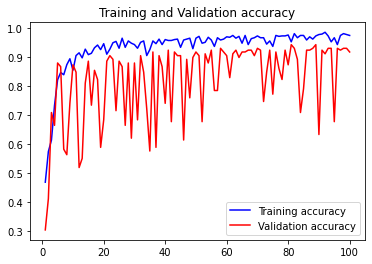

<Figure size 432x288 with 0 Axes>

In [22]:
# train processing plot
epochs=range(1,n_epochs+1)

plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

In [23]:
losses_test = []
n_test = 0
acc_test = 0
conv_net.eval()

for x, t in dataloader_test:
        n_test += t.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        y = conv_net.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_test += (pred == t).float().sum().item()
        losses_test.append(loss.tolist())

# Visualize loss & accuracy    
print('Loss: {:.3f}, Accuracy: {:.3f}'.format(np.mean(losses_test),acc_test/n_test))

Loss: 8.360, Accuracy: 0.375


In [24]:
acc_test

15.0

In [25]:
n_test

40

# ResNet18遷移学習

In [30]:
import torch
import torchvision.models as models
import torch.nn as nn

In [31]:
# FC層のクラス数を変更

model = models.resnet18(pretrained=True)
num_fcs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_fcs, 256),
    nn.Dropout(p=0.5),
    nn.ReLU(inplace=True),
    nn.Linear(256, 4)
)
model.avgpool = nn.AdaptiveAvgPool2d(1)
model = model.cuda() 

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [1]:
n_epochs = 100
lr = 0.01
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
device = 'cuda'

losstrain=[]
lossvalid=[]
Accuracytrain=[]
Accuracyvalid=[]

for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []
    # Train
    model.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]
        model.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        y = model.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())
    # Evaluate
    model.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        y = model.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())
    # Visualize loss & accuracy    
    losstrain.append(np.mean(losses_train))   
    Accuracytrain.append(acc_train/n_train)
    lossvalid.append(np.mean(losses_train))
    Accuracyvalid.append(acc_val/n_val)
    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(epoch,np.mean(losses_train),acc_train/n_train,np.mean(losses_valid),acc_val/n_val))

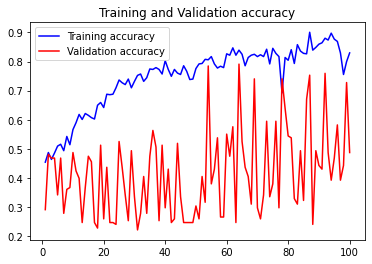

<Figure size 432x288 with 0 Axes>

In [82]:
# train processing plot
epochs=range(1,n_epochs+1)

plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

In [81]:
losses_test = []
n_test = 0
acc_test = 0
conv_net.eval()

for x, t in dataloader_test:
        n_test += t.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        y = model.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_test += (pred == t).float().sum().item()
        losses_test.append(loss.tolist())

# Visualize loss & accuracy    
print('Loss: {:.3f}, Accuracy: {:.3f}'.format(np.mean(losses_test),acc_test/n_test))

Loss: 7.789, Accuracy: 0.250


# 拡張データ確認

In [2]:
path = "./DataAugmentation"
DataPath=[]
DataLabel=[]

for root,dirs,files in os.walk(path):
    for file_name in files:
        path = os.path.join(root,file_name)
        label = os.path.join(file_name)
        DataPath.append(path)
        DataLabel.append(label[0])
# all_files.remove("../Database/KIMIA_Path_960/train/.DS_Store")
# file_label.remove(".")
print(len(DataPath))
print(len(DataLabel))

903
903


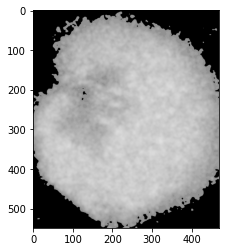

In [3]:
path = "./SegmentData/1234_STED_decon_CTCF/"
name = "1_488_STED_decon_gamma10_2.tif"
classes = ["1","2","3","4"]

img = cv2.imread(path+name)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

7
./DataAugmentation/1_488_STED_decon_gamma10_2_288.tif
./DataAugmentation/1_488_STED_decon_gamma10_2_291.tif
./DataAugmentation/1_488_STED_decon_gamma10_2_292.tif
./DataAugmentation/1_488_STED_decon_gamma10_2_294.tif
./DataAugmentation/1_488_STED_decon_gamma10_2_289.tif
./DataAugmentation/1_488_STED_decon_gamma10_2_293.tif
./DataAugmentation/1_488_STED_decon_gamma10_2_290.tif


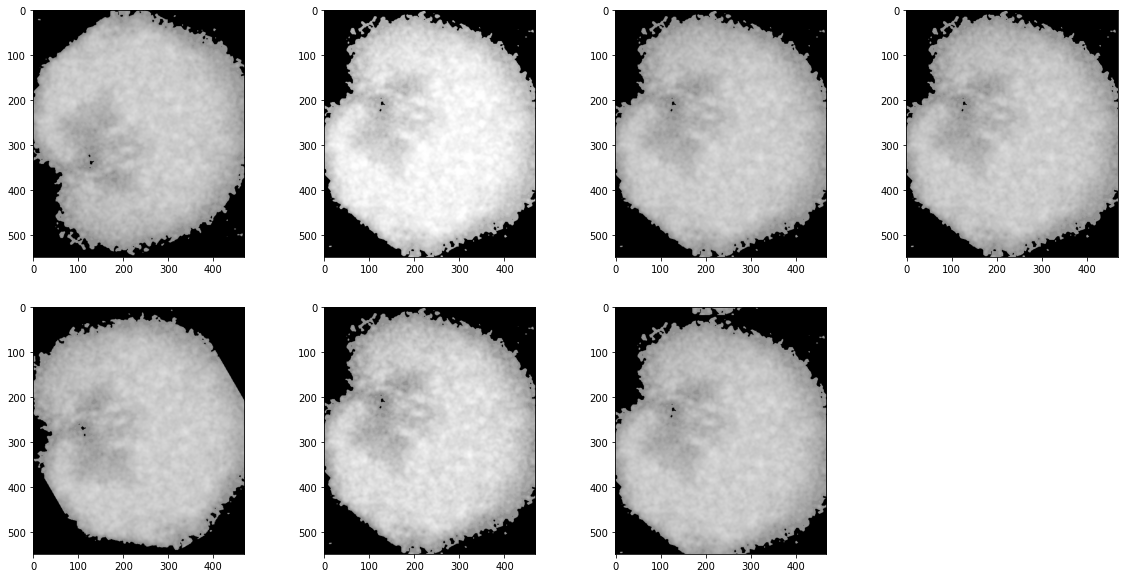

(549, 469, 3)


In [4]:
import re

similiardata = []
for path in DataPath:
#     print(file)
    if path.startswith("./DataAugmentation/1_488_STED_decon_gamma10_2_"):
        similiardata.append(path)
print(len(similiardata))
for i in similiardata:
    print(i)


fig, ax = plt.subplots(2,2, figsize = (20,10))
n=1
for data in similiardata:
    img = cv2.imread(data)
    plt.subplot(2,4,n)
    n = n+1
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print(img.shape)

# Data augmentation

In [31]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from matplotlib import pyplot
from numpy import expand_dims

In [31]:
%pwd
%ls

ClassifyBoVW.ipynb  DataBest/          DataGamma.ipynb      DataList.npy
ClassifyCNN.ipynb   DataConfirm.ipynb  DataLabelList.npy    DataOrigin/
DataAugmentation/   DataGamma/         DataList_imread.npy  SegmentData/


In [30]:
!mkdir DataAugmentation

In [34]:
# -*- coding: utf-8 -*-
import sys    
import os
import time
import re
from PIL import Image,ImageChops,ImageEnhance
 
def image_reversal(img,savefilepath,save_filename):
    """ 图像翻转"""
    lr=img.transpose(Image.FLIP_LEFT_RIGHT) # 左右翻转
    ud=img.transpose(Image.FLIP_TOP_BOTTOM) # 上下翻转
    lr.save(savefilepath+save_filename)
    ud.save(savefilepath+save_filename)
 
 
def image_rotation(img,savefilepath,save_filename):
    """图像旋转"""
    out1=img.rotate(40) # 旋转20度
    out2=img.rotate(30) # 旋转30度
    out1.save(savefilepath+save_filename)
    out2.save(savefilepath+save_filename)
 
 
def image_translation(img,savefilepath,save_filename):
    """图像平移"""
    out3=ImageChops.offset(img,20,0) # 只沿X轴平移
    out4=ImageChops.offset(img,0,20) # 只沿y轴平移
    out3.save(savefilepath+save_filename)
    out4.save(savefilepath+save_filename)
 
 
def image_brightness(img,savefilepath,save_filename):
    """亮度调整"""
    bri=ImageEnhance.Brightness(img)
    bri_img1=bri.enhance(0.8) # 小于1为减弱
    bri_img2=bri.enhance(1.2) # 大于1为增强
    bri_img1.save(savefilepath+save_filename)
    bri_img2.save(savefilepath+save_filename)
 
 
def image_chroma(img,savefilepath,save_filename):
    """色度调整"""
    col = ImageEnhance.Color(img)
    col_img1 = col.enhance(0.7) # 色度减弱
    col_img2 = col.enhance(1.3) # 色度增强
    col_img1.save(savefilepath+save_filename)
    col_img2.save(savefilepath+save_filename)
 
 
def image_contrast(img,savefilepath,save_filename):
    """对比度调整"""
    con=ImageEnhance.Contrast(img)
    con_img1=con.enhance(0.7) # 对比度减弱
    con_img2=con.enhance(1.3) # 对比度增强
    con_img1.save(savefilepath+save_filename)
    con_img2.save(savefilepath+save_filename)
 
 
def image_sharpness(img,savefilepath,save_filename):
    """锐度调整"""
    sha = ImageEnhance.Sharpness(img)
    sha_img1 = sha.enhance(0.5) # 锐度减弱
    sha_img2 = sha.enhance(1.5) # 锐度增强
    sha_img1.save(savefilepath+save_filename)
    sha_img2.save(savefilepath+save_filename)
 
 
# 定义扩充图片函数
def image_expansion(filepath,savefilepath):
    """
    :param filepath: 图片路径
    :param savefilepath: 扩充保存图片路径
    :param save_prefix: 图片前缀
    :return: 图片扩充数据集
    """
    i = 1
    for parent, dirnames, filenames in os.walk(filepath):
        for filename in filenames:
            image_path=filepath+filename
            name = re.findall(r"(.*).tif", filename)[0]
            print('正在扩充图片：%s' %filename)
            try:
                img=Image.open(image_path)
                if img.mode == "P":
                    img = img.convert('RGB')
                image_reversal(img,savefilepath,save_filename=name + "_" + str(i) + '.tif')
                i += 1
                image_rotation(img,savefilepath,save_filename=name+ "_" + str(i)+'.tif')
                i += 1
                image_translation(img,savefilepath,save_filename=name+ "_" + str(i)+'.tif')
                i += 1
                image_brightness(img,savefilepath,save_filename=name+ "_" + str(i)+'.tif')
                i += 1
                image_chroma(img,savefilepath,save_filename=name+ "_" + str(i)+'.tif')
                i += 1
                image_contrast(img,savefilepath,save_filename=name+ "_" + str(i)+'.tif')
                i += 1
                image_sharpness(img,savefilepath,save_filename=name+ "_" + str(i)+'.tif')
                i += 1
            except Exception as e:
                print(e)
                pass
 
 
if __name__ == '__main__':
    # 设置图片路径
    filepath = "./SegmentData/1234_STED_decon_CTCF/"

    # 设置扩充保存图片路径
    savefilepath ='./DataAugmentation/'
    
    time1 = time.time()
    image_expansion(filepath, savefilepath)
    time2 = time.time()
    print('总共耗时：' + str(time2 - time1) + 's')
 

正在扩充图片：3_488_STED_decon_gamma10_16.tif
正在扩充图片：3_488_STED_decon_gamma10_27.tif
正在扩充图片：4_488_STED_decon_gamma10_1.tif
正在扩充图片：4_488_STED_decon_gamma10_20.tif
正在扩充图片：3_488_STED_decon_gamma10_17.tif
正在扩充图片：2_488_STED_decon_gamma10_12.tif
正在扩充图片：3_488_STED_decon_gamma10_29.tif
正在扩充图片：4_488_STED_decon_gamma10_19.tif
正在扩充图片：3_488_STED_decon_gamma10_2.tif
正在扩充图片：2_488_STED_decon_gamma10_28.tif
正在扩充图片：4_488_STED_decon_gamma10_22.tif
正在扩充图片：4_488_STED_decon_gamma10_14.tif
正在扩充图片：2_488_STED_decon_gamma10_25.tif
正在扩充图片：3_488_STED_decon_gamma10_18.tif
正在扩充图片：4_488_STED_decon_gamma10_12.tif
正在扩充图片：3_488_STED_decon_gamma10_5.tif
正在扩充图片：3_488_STED_decon_gamma10_32.tif
正在扩充图片：3_488_STED_decon_gamma10_24.tif
正在扩充图片：1_488_STED_decon_gamma10_29.tif
正在扩充图片：3_488_STED_decon_gamma10_21.tif
正在扩充图片：3_488_STED_decon_gamma10_22.tif
正在扩充图片：4_488_STED_decon_gamma10_11.tif
正在扩充图片：4_488_STED_decon_gamma10_16.tif
正在扩充图片：1_488_STED_decon_gamma10_24.tif
正在扩充图片：3_488_STED_decon_gamma10_26.tif
正在扩充图片：1_488_STED_decon_gamm